<a href="https://colab.research.google.com/github/MittalNeha/Extensive_Vision_AI6/blob/main/week4/Session_4_Neha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
!pip install hiddenlayer
import hiddenlayer as hl

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) #14
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)#7x7
        self.conv6 = nn.Conv2d(512, 1024, 3, padding=1)#7x7 
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(1024, 32, 1)#5x5
        self.conv8 = nn.Conv2d(32, 10, 3, padding=1)#5x5 
        self.gap  = nn.AvgPool2d(3)
        self.fc1  = nn.Linear(512, 10)
        # self.conv6 = nn.Conv2d(512, 1024, 3)
        # self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.pool3(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x = (F.relu(self.conv8(F.relu(self.conv7(x)))))
        x = self.gap(x)
        
        # x = (self.conv7(x))
        # x = x.view(-1, 10)
        # x = self.fc1(x)
        return F.log_softmax(x)

# New Section

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 7, 7]       1,180,160
            Conv2d-8           [-1, 1024, 7, 7]       4,719,616
         MaxPool2d-9           [-1, 1024, 3, 3]               0
           Conv2d-10             [-1, 32, 3, 3]          32,800
           Conv2d-11             [-1, 10, 3, 3]           2,890
        AvgPool2d-12             [-1, 10, 1, 1]               0
Total params: 6,323,306
Trainable params: 6,323,306
Non-trainable params: 0
---------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:


torch.manual_seed(1)
# batch_size = 128
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    # pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    # for batch_idx, (data, target) in enumerate(pbar):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

        train_loss += loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(100. * correct / len(train_loader.dataset))



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    hist_test_loss.append(test_loss)
    hist_test_acc.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:

# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# for epoch in range(1, 5):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

Draw the network

In [8]:
def draw_network(model):
  model = model.to("cpu")
  hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))
  # Use a different color theme
  hl_graph.theme = hl.graph.THEMES["blue"].copy()
  return hl_graph

## Net 7
12->24->MP->12->24->24->MP->12->24->24->GAP->Dense->10

In [44]:
drop_out_val = 0.1
class Net7(nn.Module):
    def __init__(self):
        super().__init__()                     #Input - Output - RF
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)      #28 - 28 - 3x3
        self.bn1 = nn.BatchNorm2d(12)
        self.do1 = nn.Dropout2d(drop_out_val)
        
        self.conv2 = nn.Conv2d(12, 24, 3, padding=1)      #28 - 26 - 5x5
        self.bn2 = nn.BatchNorm2d(24)
        self.do2 = nn.Dropout2d(drop_out_val)
        
        # self.conv2_1 = nn.Conv2d(24,24, 3, padding=1)             #26 - 24 - 7x7
        # self.conv2_2 = nn.Conv2d(36, 24, 1)             #24 - 24 - 7x7
        self.pool1 = nn.MaxPool2d(2, 2)                 #28 - 14 - 14x14

        self.conv3 = nn.Conv2d(24, 12, 1)               #12 - 10 - 12x12
        self.bn3 = nn.BatchNorm2d(12)
        self.do3 = nn.Dropout2d(drop_out_val)

        self.conv4 = nn.Conv2d(12, 24, 3, padding = 1)              #10 - 8 - 14x14
        self.bn4 = nn.BatchNorm2d(24)
        self.do4 = nn.Dropout2d(drop_out_val)

        self.conv4_1 = nn.Conv2d(24, 24, 3, padding = 1)           #8 - 8 - 14x14
        self.bn4_1 = nn.BatchNorm2d(24)
        self.do4_1 = nn.Dropout2d(drop_out_val)

        self.pool2 = nn.MaxPool2d(2, 2)                 #8 -  4 - 28x28

        self.conv5 = nn.Conv2d(24, 12, 1)             #4  -  2 - 30x30
        self.bn5 = nn.BatchNorm2d(12)
        self.do5 = nn.Dropout2d(drop_out_val)

        self.conv6 = nn.Conv2d(12, 24, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6 = nn.BatchNorm2d(24)
        self.do6 = nn.Dropout2d(drop_out_val)

        self.conv6_1 = nn.Conv2d(24, 24, 3)            #3 -   1 - 32x32
        # self.bn6_1 = nn.BatchNorm2d(24)
        # self.do6_1 = nn.Dropout2d(drop_out_val)

        self.gap = nn.AvgPool2d(5)
        self.linear1 = nn.Linear(24, 10)

    def forward(self, x):
        #self is containing all variables, compulsory to pass
        #x is input image
        # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout 
        x = self.pool1(self.do2(F.relu(self.bn2(self.conv2(self.do1(F.relu( self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        x = self.pool2(self.do4_1(F.relu( self.bn4_1(self.conv4_1(self.do4(F.relu( self.bn4(self.conv4(self.do3(F.relu( self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        x =            F.relu( self.conv6_1(self.do6(F.relu( self.bn6(self.conv6(self.do5(F.relu( self.bn5(self.conv5(x))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        

        # x = self.pool1(F.relu( self.do2(self.bn2(self.conv2(F.relu( self.do1(self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        # x = self.pool2(F.relu( self.do4_1(self.bn4_1(self.conv4_1(F.relu( self.do4(self.bn4(self.conv4(F.relu( self.do3(self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        # # x = self.pool2(F.relu(self.conv4_1(F.relu(self.conv4(F.relu(self.conv3(x)))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        # # x =            F.relu( self.do6_1(self.bn6_1(self.conv6_1(F.relu( self.do6(self.bn6(self.conv6(F.relu( self.do5(self.bn5(self.conv5(x))))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        # x =            F.relu(self.conv6_1(F.relu( self.do6(self.bn6(self.conv6(F.relu( self.do5(self.bn5(self.conv5(x))))))))))              #conv5 -> ReLU -> conv6 -> ReLU
        # #x = F.relu(self.conv7(x))                                  #Dont need to perform ReLU on last layer as its output would be subject to softmax, cannot apply non-linearity twice.
        #x = (self.conv7(x))                                         #conv7 -> output
        x = self.gap(x)
        x = x.view(-1, 24)
        x = self.linear1(x)
        return F.log_softmax(x)       #log of softmax

model = Net7().to(device)

## Net 8
12->24->MP->12->24->24->MP->12->24->36->GAP->Dense->10

In [43]:
drop_out_val = 0.2
class Net8(nn.Module):
    def __init__(self):
        super().__init__()                     #Input - Output - RF
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)      #28 - 28 - 3x3
        self.bn1 = nn.BatchNorm2d(12)
        self.do1 = nn.Dropout2d(drop_out_val)
        
        self.conv2 = nn.Conv2d(12, 24, 3, padding=1)      #28 - 26 - 5x5
        self.bn2 = nn.BatchNorm2d(24)
        self.do2 = nn.Dropout2d(drop_out_val)
        
        # self.conv2_1 = nn.Conv2d(24,24, 3, padding=1)             #26 - 24 - 7x7
        # self.conv2_2 = nn.Conv2d(36, 24, 1)             #24 - 24 - 7x7
        self.pool1 = nn.MaxPool2d(2, 2)                 #28 - 14 - 14x14

        self.conv3 = nn.Conv2d(24, 12, 1)               #12 - 10 - 12x12
        self.bn3 = nn.BatchNorm2d(12)
        self.do3 = nn.Dropout2d(drop_out_val)

        self.conv4 = nn.Conv2d(12, 24, 3, padding = 1)              #10 - 8 - 14x14
        self.bn4 = nn.BatchNorm2d(24)
        self.do4 = nn.Dropout2d(drop_out_val)

        self.conv4_1 = nn.Conv2d(24, 24, 3, padding = 1)           #8 - 8 - 14x14
        self.bn4_1 = nn.BatchNorm2d(24)
        self.do4_1 = nn.Dropout2d(drop_out_val)

        self.pool2 = nn.MaxPool2d(2, 2)                 #8 -  4 - 28x28
        self.conv5 = nn.Conv2d(24, 12, 1)             #4  -  2 - 30x30
        self.bn5 = nn.BatchNorm2d(12)
        self.do5 = nn.Dropout2d(drop_out_val)

        self.conv6 = nn.Conv2d(12, 24, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6 = nn.BatchNorm2d(24)
        self.do6 = nn.Dropout2d(drop_out_val)

        self.conv6_1 = nn.Conv2d(24, 36, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6_1 = nn.BatchNorm2d(36)
        self.do6_1 = nn.Dropout2d(drop_out_val)

        #self.conv7 = nn.Conv2d(128, 10, 3)             #3 -   1 - 34x34
        self.gap = nn.AvgPool2d(7)
        self.linear1 = nn.Linear(24, 10)

    def forward(self, x):
        #self is containing all variables, compulsory to pass
        #x is input image
        # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout 
        x = self.pool1(self.do2(F.relu(self.bn2(self.conv2(self.do1(F.relu( self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        x = self.pool2(self.do4_1(F.relu( self.bn4_1(self.conv4_1(self.do4(F.relu( self.bn4(self.conv4(self.do3(F.relu( self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        x =            self.do6_1(F.relu( self.bn6_1(self.conv6_1(self.do6(F.relu( self.bn6(self.conv6(self.do5(F.relu( self.bn5(self.conv5(x))))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        
        #conv->BN->dropout->relu
        # x = self.pool1(F.relu( self.do2(self.bn2(self.conv2(F.relu( self.do1(self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        # x = self.pool2(F.relu( self.do4_1(self.bn4_1(self.conv4_1(F.relu( self.do4(self.bn4(self.conv4(F.relu( self.do3(self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        # x =            F.relu( self.do6_1(self.bn6_1(self.conv6_1(F.relu( self.do6(self.bn6(self.conv6(F.relu( self.do5(self.bn5(self.conv5(x))))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        
        x = self.gap(x)
        x = x.view(-1, 24)
        x = self.linear1(x)
        # x = self.pool2(F.relu(self.conv4_1(F.relu(self.conv4(F.relu(self.conv3(x)))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        #x = F.relu(self.conv7(x))                                  #Dont need to perform ReLU on last layer as its output would be subject to softmax, cannot apply non-linearity twice.
        #x = (self.conv7(x))                                         #conv7 -> output
        
        return F.log_softmax(x)       #log of softmax

model = Net8().to(device)

##Net 9
12->36->MP->12->24->24->MP->12->24->24->GAP->Dense->10

In [48]:
drop_out_val = 0.1
class Net7(nn.Module):
    def __init__(self):
        super().__init__()                     #Input - Output - RF
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)      #28 - 28 - 3x3
        self.bn1 = nn.BatchNorm2d(12)
        self.do1 = nn.Dropout2d(drop_out_val)
        
        self.conv2 = nn.Conv2d(12, 36, 3, padding=1)      #28 - 26 - 5x5
        self.bn2 = nn.BatchNorm2d(36)
        self.do2 = nn.Dropout2d(drop_out_val)
        
        # self.conv2_1 = nn.Conv2d(24,24, 3, padding=1)             #26 - 24 - 7x7
        # self.conv2_2 = nn.Conv2d(36, 24, 1)             #24 - 24 - 7x7
        self.pool1 = nn.MaxPool2d(2, 2)                 #28 - 14 - 14x14

        self.conv3 = nn.Conv2d(36, 12, 1)               #12 - 10 - 12x12
        self.bn3 = nn.BatchNorm2d(12)
        self.do3 = nn.Dropout2d(drop_out_val)

        self.conv4 = nn.Conv2d(12, 24, 3, padding = 1)              #10 - 8 - 14x14
        self.bn4 = nn.BatchNorm2d(24)
        self.do4 = nn.Dropout2d(drop_out_val)

        self.conv4_1 = nn.Conv2d(24, 24, 3, padding = 1)           #8 - 8 - 14x14
        self.bn4_1 = nn.BatchNorm2d(24)
        self.do4_1 = nn.Dropout2d(drop_out_val)

        self.pool2 = nn.MaxPool2d(2, 2)                 #8 -  4 - 28x28

        self.conv5 = nn.Conv2d(24, 12, 1)             #4  -  2 - 30x30
        self.bn5 = nn.BatchNorm2d(12)
        self.do5 = nn.Dropout2d(drop_out_val)

        self.conv6 = nn.Conv2d(12, 24, 3, padding = 1)            #3 -   1 - 32x32
        self.bn6 = nn.BatchNorm2d(24)
        self.do6 = nn.Dropout2d(drop_out_val)

        self.conv6_1 = nn.Conv2d(24, 24, 3)            #3 -   1 - 32x32
        # self.bn6_1 = nn.BatchNorm2d(24)
        # self.do6_1 = nn.Dropout2d(drop_out_val)

        self.gap = nn.AvgPool2d(5)
        self.linear1 = nn.Linear(24, 10)

    def forward(self, x):
        #self is containing all variables, compulsory to pass
        #x is input image
        # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout 
        x = self.pool1(self.do2(F.relu(self.bn2(self.conv2(self.do1(F.relu( self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        x = self.pool2(self.do4_1(F.relu( self.bn4_1(self.conv4_1(self.do4(F.relu( self.bn4(self.conv4(self.do3(F.relu( self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        x =            F.relu( self.conv6_1(self.do6(F.relu( self.bn6(self.conv6(self.do5(F.relu( self.bn5(self.conv5(x))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        

        # x = self.pool1(F.relu( self.do2(self.bn2(self.conv2(F.relu( self.do1(self.bn1(self.conv1(x)))))))))   #conv1 -> ReLU -> conv2 -> ReLU -> max pool
        # x = self.pool2(F.relu( self.do4_1(self.bn4_1(self.conv4_1(F.relu( self.do4(self.bn4(self.conv4(F.relu( self.do3(self.bn3(self.conv3(x)))))))))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        # # x = self.pool2(F.relu(self.conv4_1(F.relu(self.conv4(F.relu(self.conv3(x)))))))   #conv3 -> ReLU -> conv4 -> ReLU -> max pool
        # # x =            F.relu( self.do6_1(self.bn6_1(self.conv6_1(F.relu( self.do6(self.bn6(self.conv6(F.relu( self.do5(self.bn5(self.conv5(x))))))))))))               #conv5 -> ReLU -> conv6 -> ReLU
        # x =            F.relu(self.conv6_1(F.relu( self.do6(self.bn6(self.conv6(F.relu( self.do5(self.bn5(self.conv5(x))))))))))              #conv5 -> ReLU -> conv6 -> ReLU
        # #x = F.relu(self.conv7(x))                                  #Dont need to perform ReLU on last layer as its output would be subject to softmax, cannot apply non-linearity twice.
        #x = (self.conv7(x))                                         #conv7 -> output
        x = self.gap(x)
        x = x.view(-1, 24)
        x = self.linear1(x)
        return F.log_softmax(x)       #log of softmax

model = Net7().to(device)

## Summary and training

In [49]:
summary(model, input_size=(1, 28, 28))
# graph = draw_network(model)
# graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             120
       BatchNorm2d-2           [-1, 12, 28, 28]              24
         Dropout2d-3           [-1, 12, 28, 28]               0
            Conv2d-4           [-1, 36, 28, 28]           3,924
       BatchNorm2d-5           [-1, 36, 28, 28]              72
         Dropout2d-6           [-1, 36, 28, 28]               0
         MaxPool2d-7           [-1, 36, 14, 14]               0
            Conv2d-8           [-1, 12, 14, 14]             444
       BatchNorm2d-9           [-1, 12, 14, 14]              24
        Dropout2d-10           [-1, 12, 14, 14]               0
           Conv2d-11           [-1, 24, 14, 14]           2,616
      BatchNorm2d-12           [-1, 24, 14, 14]              48
        Dropout2d-13           [-1, 24, 14, 14]               0
           Conv2d-14           [-1, 24,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [12]:
#reset the Network
# model = Net7().to(device)

In [50]:
hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

Epoch:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.1301, Accuracy: 9610/10000 (96.100%)

Epoch:  2

Test set: Average loss: 0.0734, Accuracy: 9769/10000 (97.690%)

Epoch:  3

Test set: Average loss: 0.0525, Accuracy: 9845/10000 (98.450%)

Epoch:  4

Test set: Average loss: 0.0496, Accuracy: 9832/10000 (98.320%)

Epoch:  5

Test set: Average loss: 0.0470, Accuracy: 9846/10000 (98.460%)

Epoch:  6

Test set: Average loss: 0.0406, Accuracy: 9876/10000 (98.760%)

Epoch:  7

Test set: Average loss: 0.0368, Accuracy: 9884/10000 (98.840%)

Epoch:  8

Test set: Average loss: 0.0352, Accuracy: 9884/10000 (98.840%)

Epoch:  9

Test set: Average loss: 0.0353, Accuracy: 9886/10000 (98.860%)

Epoch:  10

Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.090%)

Epoch:  11

Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.010%)

Epoch:  12

Test set: Average loss: 0.0333, Accuracy: 9894/10000 (98.940%)

Epoch:  13

Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.070%)

Epoch:  14

Test set: Average l

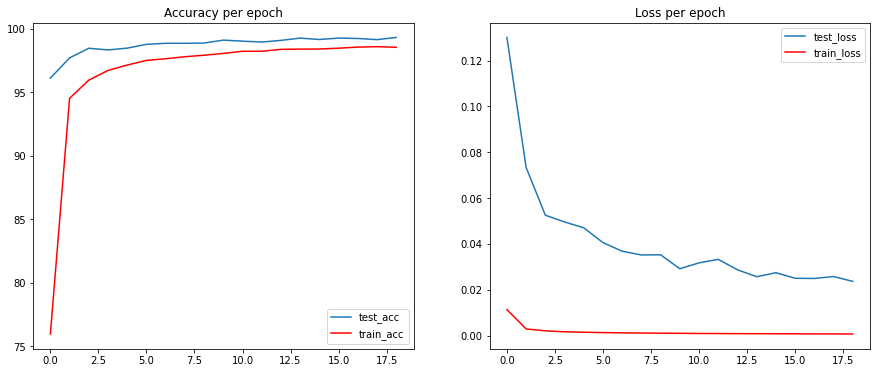

In [51]:
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 20):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
training_curves()

In [ ]:
training_curves()

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(hist_test_acc))
  plt.plot(np.array(hist_train_acc), 'r')
  plt.legend(["test_acc", "train_acc"])
  plt.title("Accuracy per epoch")

  plt.subplot(1,2,2)
  plt.plot(hist_test_loss)
  plt.plot(hist_train_loss, 'r')
  plt.legend(["test_loss", "train_loss"])
  plt.title("Loss per epoch")


In [ ]:
len(hist_train_loss)